第9章: RNN, CNN


80. ID番号への変換

In [1]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip NewsAggregatorDataset.zip

--2025-01-31 12:24:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘NewsAggregatorDataset.zip’

NewsAggregatorDatas     [  <=>               ]  27.87M  88.9MB/s    in 0.3s    

2025-01-31 12:24:16 (88.9 MB/s) - ‘NewsAggregatorDataset.zip’ saved [29224203]

Archive:  NewsAggregatorDataset.zip
  inflating: 2pageSessions.csv       
   creating: __MACOSX/
  inflating: __MACOSX/._2pageSessions.csv  
  inflating: newsCorpora.csv         
  inflating: __MACOSX/._newsCorpora.csv  
  inflating: readme.txt              
  inflating: __MACOSX/._readme.txt   


In [2]:
!head -10 ./newsCorpora.csv

1	Fed official says weak data caused by weather, should not slow taper	http://www.latimes.com/business/money/la-fi-mo-federal-reserve-plosser-stimulus-economy-20140310,0,1312750.story\?track=rss	Los Angeles Times	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.latimes.com	1394470370698
2	Fed's Charles Plosser sees high bar for change in pace of tapering	http://www.livemint.com/Politics/H2EvwJSK2VE6OF7iK1g3PP/Feds-Charles-Plosser-sees-high-bar-for-change-in-pace-of-ta.html	Livemint	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.livemint.com	1394470371207
3	US open: Stocks fall after Fed official hints at accelerated tapering	http://www.ifamagazine.com/news/us-open-stocks-fall-after-fed-official-hints-at-accelerated-tapering-294436	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www.ifamagazine.com	1394470371550
4	Fed risks falling 'behind the curve', Charles Plosser says	http://www.ifamagazine.com/news/fed-risks-falling-behind-the-curve-charles-plosser-says-294430	IFA Magazine	b	ddUyU0VZz0BRneMioxUPQVP6sIxvM	www

In [3]:
# 読込時のエラー回避のためダブルクォーテーションをシングルクォーテーションに置換
!sed -e 's/"/'\''/g' ./newsCorpora.csv > ./newsCorpora_re.csv

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# データの読込
df = pd.read_csv('./newsCorpora_re.csv', header=None, sep='\t', names=['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP'])

# データの抽出
df = df.loc[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']), ['TITLE', 'CATEGORY']]

# データの分割
train, valid_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=123, stratify=df['CATEGORY'])
valid, test = train_test_split(valid_test, test_size=0.5, shuffle=True, random_state=123, stratify=valid_test['CATEGORY'])
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# 事例数の確認
print('【学習データ】')
print(train['CATEGORY'].value_counts())
print('【検証データ】')
print(valid['CATEGORY'].value_counts())
print('【評価データ】')
print(test['CATEGORY'].value_counts())


【学習データ】
CATEGORY
b    4501
e    4235
t    1220
m     728
Name: count, dtype: int64
【検証データ】
CATEGORY
b    563
e    529
t    153
m     91
Name: count, dtype: int64
【評価データ】
CATEGORY
b    563
e    530
t    152
m     91
Name: count, dtype: int64


In [5]:
from collections import defaultdict
import string

# 単語の頻度集計
d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))  # 記号をスペースに置換するテーブル
for text in train['TITLE']:
  for word in text.translate(table).split():
    d[word] += 1
d = sorted(d.items(), key=lambda x:x[1], reverse=True)

# 単語ID辞書の作成
word2id = {word: i + 1 for i, (word, cnt) in enumerate(d) if cnt > 1}  # 出現頻度が2回以上の単語を登録

print(f'ID数: {len(set(word2id.values()))}\n')
print('---頻度上位20語---')
for key in list(word2id)[:20]:
    print(f'{key}: {word2id[key]}')

ID数: 9405

---頻度上位20語---
to: 1
s: 2
in: 3
on: 4
UPDATE: 5
as: 6
US: 7
for: 8
The: 9
of: 10
1: 11
To: 12
2: 13
the: 14
and: 15
In: 16
Of: 17
a: 18
at: 19
A: 20


In [6]:
import torch

def tokenizer(text, word2id=word2id, unk=0):
  """ 入力テキストをスペースで分割しID列に変換(辞書になければunkで指定した数字を設定)"""
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
  return [word2id.get(word, unk) for word in text.translate(table).split()]


In [7]:
# 確認
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'テキスト: {text}')
print(f'ID列: {tokenizer(text)}')

テキスト: Amazon Plans to Fight FTC Over Mobile-App Purchases
ID列: [169, 539, 1, 683, 1237, 82, 279, 1898, 4199]


81. RNNによる予測

In [8]:
import torch
from torch import nn

class RNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.rnn = nn.RNN(emb_size, hidden_size, nonlinearity='tanh', batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    self.batch_size = x.size()[0]
    hidden = self.init_hidden()  # h0のゼロベクトルを作成
    emb = self.emb(x)
    # emb.size() = (batch_size, seq_len, emb_size)
    out, hidden = self.rnn(emb, hidden)
    # out.size() = (batch_size, seq_len, hidden_size)
    out = self.fc(out[:, -1, :])
    # out.size() = (batch_size, output_size)
    return out

  def init_hidden(self):
    hidden = torch.zeros(1, self.batch_size, self.hidden_size)
    return hidden


In [9]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
  def __init__(self, X, y, tokenizer):
    self.X = X
    self.y = y
    self.tokenizer = tokenizer

  def __len__(self):  # len(Dataset)で返す値を指定
    return len(self.y)

  def __getitem__(self, index):  # Dataset[index]で返す値を指定
    text = self.X[index]
    inputs = self.tokenizer(text)

    return {
      'inputs': torch.tensor(inputs, dtype=torch.int64),
      'labels': torch.tensor(self.y[index], dtype=torch.int64)
    }

In [10]:
# ラベルベクトルの作成
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

# Datasetの作成
dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

print(f'len(Dataset)の出力: {len(dataset_train)}')
print('Dataset[index]の出力:')
for var in dataset_train[1]:
  print(f'  {var}: {dataset_train[1][var]}')

len(Dataset)の出力: 10684
Dataset[index]の出力:
  inputs: tensor([ 169,  539,    1,  683, 1237,   82,  279, 1898, 4199])
  labels: 1


In [11]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.2779, 0.2124, 0.2856, 0.2240]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2453, 0.3839, 0.2503, 0.1205]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3486, 0.1758, 0.2529, 0.2228]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1695, 0.3487, 0.2453, 0.2364]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1717, 0.3118, 0.2814, 0.2351]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3346, 0.2828, 0.1939, 0.1888]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3842, 0.1893, 0.3088, 0.1177]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1713, 0.1272, 0.4817, 0.2199]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1368, 0.3505, 0.1338, 0.3789]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2275, 0.4801, 0.1297, 0.1627]], grad_fn=<SoftmaxBackward0>)


82. 確率的勾配降下法による学習

In [12]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, criterion=None):
  """損失・正解率を計算"""
  dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      # デバイスの指定
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)

      # 順伝播
      outputs = model(inputs)

      # 損失計算
      if criterion != None:
        loss += criterion(outputs, labels).item()

      # 正解率計算
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()

  return loss / len(dataset), correct / total


def train_model(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, collate_fn=None, device=None):
  """モデルの学習を実行し、損失・正解率のログを返す"""
  # デバイスの指定
  model.to(device)

  # dataloaderの作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
  dataloader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False)

  # スケジューラの設定
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  for epoch in range(num_epochs):
    # 開始時刻の記録
    s_time = time.time()

    # 訓練モードに設定
    model.train()
    for data in dataloader_train:
      # 勾配をゼロで初期化
      optimizer.zero_grad()

      # 順伝播 + 誤差逆伝播 + 重み更新
      inputs = data['inputs'].to(device)
      labels = data['labels'].to(device)
      outputs = model.forward(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # 評価モードに設定
    model.eval()

    # 損失と正解率の算出
    loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, criterion=criterion)
    loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, criterion=criterion)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントの保存
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

    # 終了時刻の記録
    e_time = time.time()

    # ログを出力
    print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec')

    # 検証データの損失が3エポック連続で低下しなかった場合は学習終了
    if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break

    # スケジューラを1ステップ進める
    scheduler.step()

  return {'train': log_train, 'valid': log_valid}


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train')
  ax[0].plot(np.array(log['valid']).T[0], label='valid')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train')
  ax[1].plot(np.array(log['valid']).T[1], label='valid')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [14]:
# パラメータの設定
VOCAB_SIZE = len(set(word2id.values())) + 1  # 辞書のID数 + パディングID
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
LEARNING_RATE = 1e-3
BATCH_SIZE = 1
NUM_EPOCHS = 10

# モデルの定義
model = RNN(VOCAB_SIZE, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# モデルの学習
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, criterion, optimizer, NUM_EPOCHS)

epoch: 1, loss_train: 1.1119, accuracy_train: 0.5161, loss_valid: 1.1454, accuracy_valid: 0.4760, 51.1401sec
epoch: 2, loss_train: 1.0175, accuracy_train: 0.5898, loss_valid: 1.0899, accuracy_valid: 0.5367, 52.5569sec
epoch: 3, loss_train: 0.8577, accuracy_train: 0.6837, loss_valid: 0.9637, accuracy_valid: 0.6392, 53.5811sec
epoch: 4, loss_train: 0.7175, accuracy_train: 0.7454, loss_valid: 0.8374, accuracy_valid: 0.7021, 50.2532sec
epoch: 5, loss_train: 0.6281, accuracy_train: 0.7757, loss_valid: 0.7830, accuracy_valid: 0.7283, 49.6855sec
epoch: 6, loss_train: 0.5533, accuracy_train: 0.8066, loss_valid: 0.7311, accuracy_valid: 0.7433, 49.2654sec
epoch: 7, loss_train: 0.5036, accuracy_train: 0.8180, loss_valid: 0.7161, accuracy_valid: 0.7380, 48.6038sec
epoch: 8, loss_train: 0.4642, accuracy_train: 0.8315, loss_valid: 0.6920, accuracy_valid: 0.7567, 48.0244sec
epoch: 9, loss_train: 0.4481, accuracy_train: 0.8353, loss_valid: 0.6861, accuracy_valid: 0.7665, 49.4014sec
epoch: 10, loss_tra

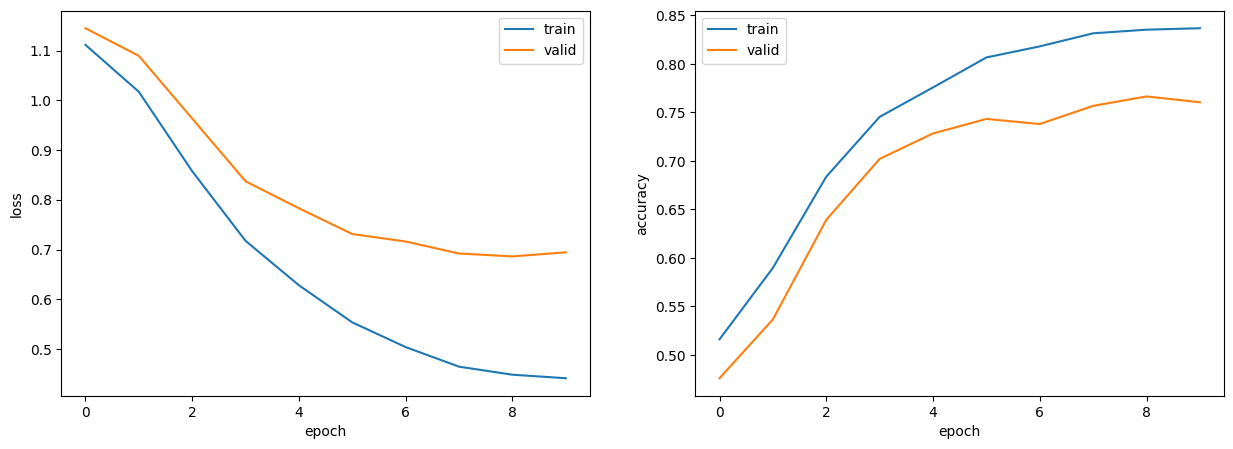

正解率（学習データ）：0.837
正解率（評価データ）：0.770


In [17]:
# ログの可視化
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test)
print(f'正解率（学習データ）：{acc_train:.3f}')
print(f'正解率（評価データ）：{acc_test:.3f}')